Define Neal's Funnel where $p(x,y) = N(y|0,3) N(x|0,\exp(y/2))$.

In [1]:
from beanmachine.ppl.experimental.tests.vi.neals_funnel import NealsFunnel
nf = NealsFunnel()

Visualize the PDF of Neal's funnel on a grid

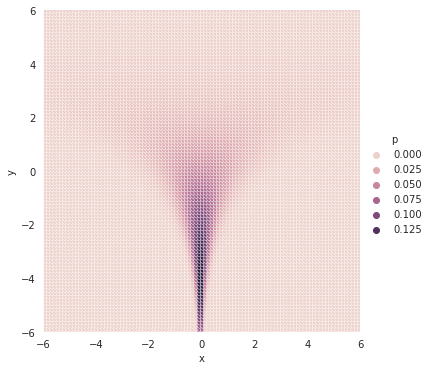

In [2]:
import torch

import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = nf.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Draw some samples from Neal's funnel and plot a KDE

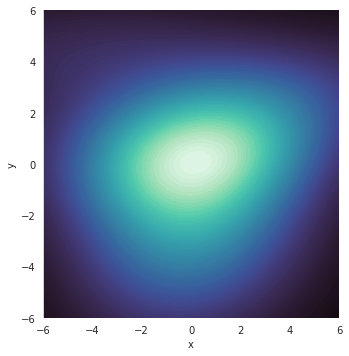

In [3]:
nf_samples = nf.sample(sample_shape=(100,2)).squeeze().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

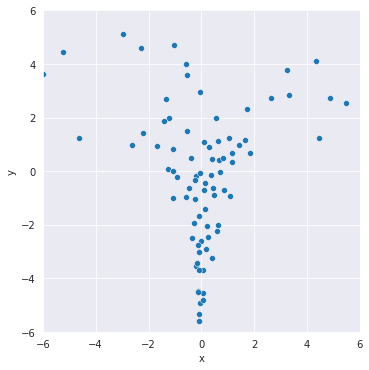

In [4]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Perform IAF Variational Approximation

In [5]:
import torch.distributions as dist

from beanmachine.ppl.experimental.vi.VariationalInfer import VariationalApproximation

vi = VariationalApproximation(
    target_log_prob=nf.log_prob,
    base_dist=dist.MultivariateNormal,
    base_args={
        'loc': torch.zeros(2), 
        'covariance_matrix': torch.eye(2),
    })
vi.train(epochs=1000)

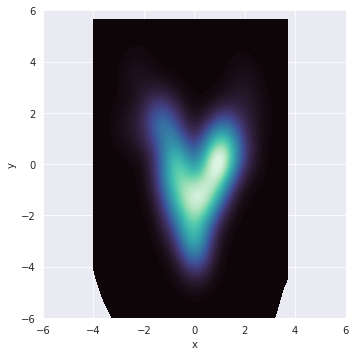

In [6]:
vi_samples = vi.sample((100,)).detach().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

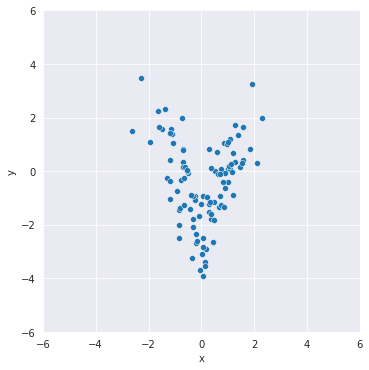

In [7]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

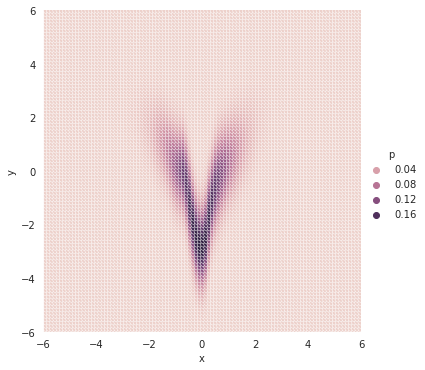

In [8]:
xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy().flatten(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

In [9]:
import scipy.stats

print(
    scipy.stats.ks_2samp(nf_samples[:,0], vi_samples[:,0]).pvalue,
    scipy.stats.ks_2samp(nf_samples[:,1], vi_samples[:,1]).pvalue,
)

0.1548386665118475 0.0002248739317492479


 ## GMM approximation to NF

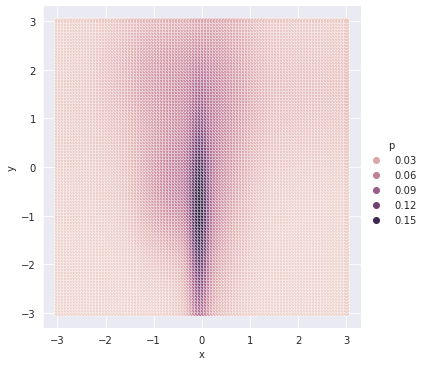

In [10]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.optim

K = 7
mix = torch.ones(K) / K
mu = nn.Parameter(torch.randn(K,2))
sigma = nn.Parameter(torch.abs(torch.randn(K,2)))

optim = torch.optim.Adam([
    mu, sigma
], lr=1e-2)

for _ in range(100):
    optim.zero_grad()
    x = nf.sample((100,))
    gmm = dist.MixtureSameFamily(
        dist.Categorical(logits=mix),
        dist.Independent(
            dist.Normal(mu, sigma),
            1))
    loss = -gmm.log_prob(x).sum()
    loss.backward()
    optim.step()

gmm = dist.MixtureSameFamily(
    dist.Categorical(logits=mix),
    dist.Independent(
        dist.Normal(mu, sigma),
        1))
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = gmm.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

## Do the same for GMM

In [11]:
import torch.distributions as dist

def gmm(x):
    return torch.log(
        0.5*torch.exp(dist.MultivariateNormal(torch.tensor([-2,-1]), 0.5*torch.eye(2)).log_prob(x)) 
        + 0.5*torch.exp(dist.MultivariateNormal(torch.tensor([1,2]), 0.5*torch.eye(2)).log_prob(x)))

vi = VariationalApproximation(
    target_log_prob=gmm,
    base_dist=dist.MultivariateNormal,
    base_args={'loc': nn.Parameter(torch.zeros(2)), 
               'covariance_matrix': torch.eye(2),
              },
    lr=1e-1)
vi.train(epochs=500)

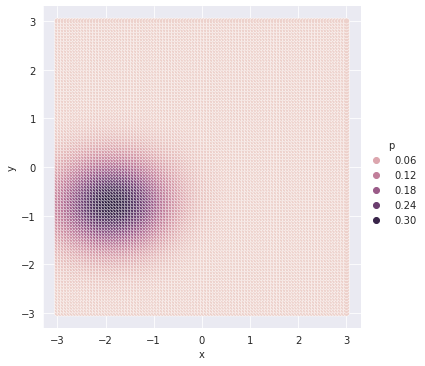

In [12]:
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

Compare against ground truth

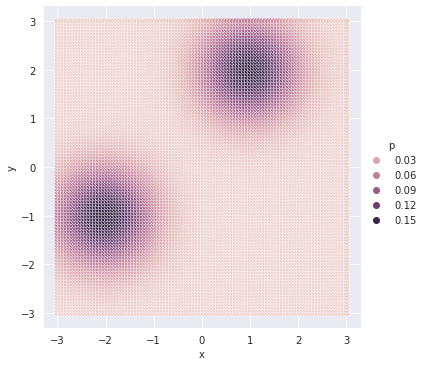

In [13]:
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = gmm(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

# Investigate heavy-tailed base distribution

In [14]:
from torch import tensor
import torch.nn as nn
import torch.distributions as dist

from beanmachine.ppl.experimental.vi.VariationalInfer import VariationalApproximation


target = dist.Cauchy(-2, 1)

vi_normal = VariationalApproximation(
    target_log_prob=target.log_prob,
    base_dist=dist.Normal,
    base_args={'loc': nn.Parameter(tensor(0.0)), 
               'scale': tensor(1.0)},
    lr=1e-1)
vi_normal.train(epochs=300)

vi_student = VariationalApproximation(
    target_log_prob=target.log_prob,
    base_dist=dist.StudentT,
    base_args={
        'df': nn.Parameter(tensor(1.0)),
        'loc': tensor(0.0),
        'scale': tensor(1.0),
    },
    lr=1e-1)
vi_student.train(epochs=300)

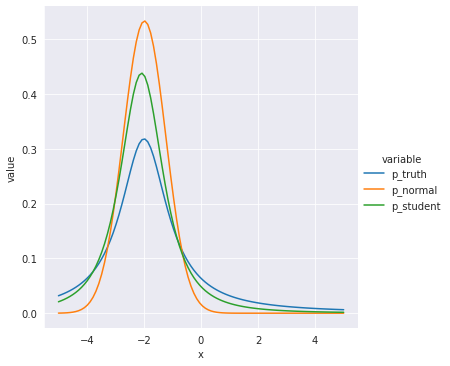

In [15]:
import torch
import seaborn as sns
import pandas as pd

x = torch.linspace(-5, 5).unsqueeze(1)
p_truth = torch.exp(target.log_prob(x))
p_normal = torch.exp(vi_normal.log_prob(x))
p_student = torch.exp(vi_student.log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p_truth": p_truth.flatten().detach().numpy(),
    "p_normal": p_normal.flatten().detach().numpy(),
    "p_student": p_student.flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")

In [16]:
vi_student.flow_stack.base_dist(**vi_student.flow_stack.base_args)

StudentT(df: 2.083681344985962, loc: 0.0, scale: 1.0)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1.0)]

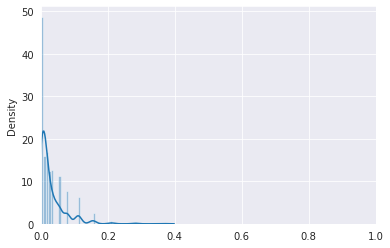

In [23]:
import numpy as np
import scipy.stats

g = sns.distplot([scipy.stats.ks_2samp(
    target.sample((100,)).detach().flatten(),
    vi_normal.sample((100,)).detach().flatten(),
).pvalue for _ in range(1000)])
g.set(xlim=[0, 1])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1.0)]

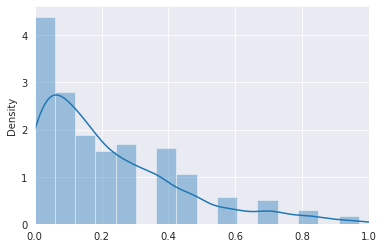

In [24]:
import numpy as np
import scipy.stats

g = sns.distplot([scipy.stats.ks_2samp(
    target.sample((100,)).detach().flatten(),
    vi_student.sample((100,)).detach().flatten(),
).pvalue for _ in range(1000)])
g.set(xlim=[0, 1])